In [2]:
# Copyright 2020 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#      https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/karajendran/Feast-on-Google-Cloud/blob/master/Feast_powered_Feature_Store_on_Google_Cloud_for_Recommendation_System.ipynb)

 # Overview
Feast-powered Feature Store on Google Cloud for Product Recommendation System

## Prerequisites

1. [Create a new project](https://console.cloud.google.com/cloud-resource-manager)
2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)
3. Enable the following APIs:
    - [BigQuery](https://console.cloud.google.com/apis/library/bigquery.googleapis.com)
    - [BigTable](https://console.cloud.google.com/apis/library/bigtable.googleapis.com)
    - [Cloud BigTable Admin API](https://console.developers.google.com/apis/api/bigtableadmin.googleapis.com)

# Installation and set up

### Install Feast

Feast can be installed using `pip`. This installation includes a Python package as well as a CLI.

Feast contains some packages which conflict with the default versions installed in Colab. **After running this cell, restart the runtime to continue** (Runtime > Restart runtime.)

In [3]:
%%sh
# Restart the runtime after executing this cell!
pip install feast['gcp'] -U -q
pip install jedi==0.17.2 -U -q
pip install "setuptools==66.0.0.0" -U -q # installed to suppress some setuptools specific warnings
echo "Restart the runtime now"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.1/293.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Set configurations

In [8]:
PROJECT_ID= "cloud-sa-ml" #@param {type:"string"}
BUCKET_NAME= "recsys-test-run" #@param {type:"string"} custom
BIGQUERY_DATASET_NAME="recsys_offline_store_test_run" #@param {type:"string"} custom
BIGTABLE_INSTANCE_NAME="recsys-online-store-test-run" #@param {type:"string"} custom
REGION="us-west1" #@param {type:"string"} custom
BIGTABLE_INSTANCE_ZONE="us-west1-a" #@param {type:"string"} custom
BIGTABLE_CLUSTER_ID="recsys" #@param {type:"string"} custom

! gcloud config set project $PROJECT_ID
%env GOOGLE_CLOUD_PROJECT=$PROJECT_ID
!echo project_id = $PROJECT_ID > ~/.bigqueryrc
# Extra commands to remove warnings
%env PYTHONWARNINGS=ignore
%env JUPYTER_PLATFORM_DIRS=1
! jupyter --paths

Updated property [core/project].
env: GOOGLE_CLOUD_PROJECT=cloud-sa-ml
env: PYTHONWARNINGS=ignore
env: JUPYTER_PLATFORM_DIRS=1
config:
    /root/.config/jupyter
    /root/.local/etc/jupyter
    /usr/etc/jupyter
    /etc/xdg/jupyter
data:
    /root/.local/share/jupyter
    /usr/local/share/jupyter
    /usr/share/jupyter
runtime:
    /root/.local/share/jupyter/runtime


## Authenticate into Google Cloud

Feast spins up infrastructure on Google Cloud using the credentials in our environment. Run the following cell to log into Google Cloud:

In [3]:
from google.colab import auth
auth.authenticate_user(project_id=PROJECT_ID)

## Create a bucket
Run the following cell to create your Cloud Storage bucket.

In [26]:
from google.cloud import storage

def create_bucket(bucket_name: str, location: str, storage_class='STANDARD'):
  """
  The function creates a Cloud Storage Bucket if don't exist.
  """
  storage_client = storage.Client()

  bucket = storage_client.bucket(bucket_name)
  if bucket.exists():
    return f'Bucket {bucket.name} already exists.'
  bucket.storage_class = storage_class
  bucket = storage_client.create_bucket(bucket, location=location)
  return f'Bucket {bucket.name} successfully created.'

In [32]:
#Create Cloud Storage Bucket
create_bucket(BUCKET_NAME,REGION)

'Bucket recsys-test-run already exists.'

## Create Bigtable Instance
Run the following cell to create your Bigtable Instance for online feature store

In [5]:
from google.cloud.bigtable import Client
from google.cloud.bigtable import enums

def create_bt_instance():
  """
  The function creates a Bigtable instance if don't exist.
  """
  my_instance_id = BIGTABLE_INSTANCE_NAME
  my_cluster_id = BIGTABLE_CLUSTER_ID
  location_id = BIGTABLE_INSTANCE_ZONE
  serve_nodes = 1
  storage_type = enums.StorageType.SSD
  labels = {"feast-tutorial": "part-2"}

  client = Client(admin=True)
  instance = client.instance(my_instance_id, labels=labels)
  if instance.exists():
    return f'Instance: {my_instance_id} already exists'
  cluster = instance.cluster(
      my_cluster_id,
      location_id=location_id,
      serve_nodes=serve_nodes,
      default_storage_type=storage_type,
  )
  operation = instance.create(clusters=[cluster])

  # We want to make sure the operation completes.
  operation.result(timeout=100)
  return f'Created instance: {my_instance_id}'

In [31]:
#Create Bigtable Instance
create_bt_instance()

'Instance: recsys-online-store-test-run already exists'

##Create BigQuery Dataset

In [28]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
def create_bq_ds(PROJECT_ID: str,
                 BIGQUERY_DATASET_NAME: str,
                 REGION: str
                 ):
  """The function creates a BigQuery dataset if don't exist.
      Args:
        PROJECT_ID:(:obj:`str`): Google Cloud project for deployment
        BIGQUERY_DATASET_NAME:(:obj:`str`): Name of the dataset.
        REGION:(:obj:`str`): Location of the Google Cloud region
          of the BigQuery dataset
  """

  client = bigquery.Client()
  dataset_id = f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}"

  ds_found = True
  try:
    client.get_dataset(dataset_id)  # Make an API request.
    print('Dataset {} already exists'.format(dataset_id))
  except NotFound:
    print('Dataset {} is not found'.format(dataset_id))
    ds_found = False

  import traceback
  if ds_found is False:
    try:
      # Construct a full Dataset object to send to the API.
      dataset = bigquery.Dataset(dataset_id)
      dataset.location = REGION.split('-')[0].upper()
      dataset = client.create_dataset(dataset)  # Make an API request.
      print('Created dataset {}.{} in location: {}.'.\
            format(client.project, dataset.dataset_id, dataset.location))
    except Exception as e:
      error = traceback.format_exc()
      print(error)
      print(e)
      raise RuntimeError(f"Can't create the BigQuery DS {dataset_id}")

In [30]:
#Create BigQuery Dataset
create_bq_ds(PROJECT_ID, BIGQUERY_DATASET_NAME,REGION)

Dataset cloud-sa-ml.recsys_offline_store_test_run already exists


## Initialize the feature repository

In Feast, you define your features using configuration stored in a repository. To start, initialize a feature repository.

In [10]:
%%bash
cd /content/
rm -rf RecSys/ # clean up if already ran this before
feast --log-level=error init -m RecSys

Feast is an open source project that collects anonymized error reporting and usage statistics. To opt out or learn more see https://docs.feast.dev/reference/usage

Creating a new Feast repository in /content/RecSys.



In [11]:
%cd /content/RecSys/feature_repo
! ls

/content/RecSys/feature_repo
feature_store.yaml  __init__.py  __pycache__


Next, we'll edit the `feature_store.yaml` file to reference our bucket. Note that the `project` field in this file refers to the Feast concept of a project, not a Google Cloud project.

In [12]:
feature_store = \
f"""project: RecSys
registry: gs://{BUCKET_NAME}/registry.db
provider: gcp
entity_key_serialization_version: 2
offline_store:
  type: bigquery
  dataset: {BIGQUERY_DATASET_NAME}
online_store:
  type: bigtable
  project_id: {PROJECT_ID}
  instance: {BIGTABLE_INSTANCE_NAME}
  max_versions: 2"""

with open('feature_store.yaml', "w") as feature_store_file:
    feature_store_file.write(feature_store)

# Print our feature_store.yaml
! cat feature_store.yaml

project: RecSys
registry: gs://recsys-test-run/registry.db
provider: gcp
entity_key_serialization_version: 2
offline_store:
  type: bigquery
  dataset: recsys_offline_store_test_run
online_store:
  type: bigtable
  project_id: cloud-sa-ml
  instance: recsys-online-store-test-run
  max_versions: 2

At this point, we've configured Feast to leverage our Google Cloud services, but haven't registered any features yet! Let's create features.

#Dataset


TheLook is a fictitious eCommerce clothing site developed by the Looker team (and programmatically regenerated).

- The dataset contains information about customers, products, orders, logistics, web events and digital marketing campaigns. The contents of this dataset are synthetic, and are provided to industry practitioners for the purpose of product discovery, testing, and evaluation.
- This public dataset is hosted in Google BigQuery and is included in BigQuery's 1TB/mo of free tier processing. This means that each user receives 1TB of free BigQuery processing every month, which can be used to run queries on this public dataset.

Tables used from this public dataset are:
* `bigquery-public-data.thelook_ecommerce.order_items`
* `bigquery-public-data.thelook_ecommerce.products`

## Preview the raw data

In [13]:
from google.cloud import bigquery
from google.cloud.exceptions import NotFound
import pandas as pd

def execute_sql(sql_query: str) -> pd.DataFrame:
  """The function executes SQL query in BigQuery and returns the result as a dataframe
  """
  client = bigquery.Client()
  try:
    client = bigquery.Client()
    query_job = client.query(sql_query)  # Make an API request.
    return query_job.result().to_dataframe()  # Waits for job to complete.
  except Exception as e:
    import traceback
    error = traceback.format_exc()
    print(error)
    print(e)
    raise RuntimeError(f"Can't execute the query {sql_query}")

In [14]:
# Note that a single order is represented with multiple rows (one row for each product in the order)
orders_df = execute_sql(
  """
  SELECT
    *
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items`
  WHERE status = 'Complete' AND delivered_at >= TIMESTAMP("2023-01-26 10:22:00+00:00")
  ORDER BY order_id
  LIMIT 20;
  """
)
orders_df

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,1,1,2,18173,3,Complete,2023-06-22 14:05:14+00:00,2023-06-22 20:29:00+00:00,2023-06-25 13:44:00+00:00,NaT,20.000000
1,8,6,5,20327,20,Complete,2023-01-24 18:17:07+00:00,2023-01-24 20:18:00+00:00,2023-01-26 10:22:00+00:00,NaT,139.990005
2,7,6,5,24778,18,Complete,2023-01-24 16:05:20+00:00,2023-01-24 20:18:00+00:00,2023-01-26 10:22:00+00:00,NaT,20.990000
3,16,13,14,3399,44,Complete,2023-07-07 05:57:03+00:00,2023-07-09 16:13:00+00:00,2023-07-12 08:50:00+00:00,NaT,89.000000
4,21,18,19,21422,57,Complete,2023-07-14 12:17:18.012879+00:00,2023-07-14 22:18:43.012879+00:00,2023-07-15 20:45:43.012879+00:00,NaT,138.000000
5,27,21,20,22040,73,Complete,2023-05-07 02:52:04+00:00,2023-05-08 06:44:00+00:00,2023-05-12 09:40:00+00:00,NaT,69.500000
6,25,21,20,17720,67,Complete,2023-05-10 02:47:14+00:00,2023-05-08 06:44:00+00:00,2023-05-12 09:40:00+00:00,NaT,38.770000
7,26,21,20,23904,71,Complete,2023-05-09 01:39:31+00:00,2023-05-08 06:44:00+00:00,2023-05-12 09:40:00+00:00,NaT,254.949997
8,24,21,20,29003,64,Complete,2023-05-11 03:46:12+00:00,2023-05-08 06:44:00+00:00,2023-05-12 09:40:00+00:00,NaT,17.990000
9,72,50,38,7953,194,Complete,2023-02-27 23:26:52+00:00,2023-03-02 18:47:00+00:00,2023-03-06 09:22:00+00:00,NaT,158.000000


In [15]:
products_df = execute_sql(
  """
  SELECT
    *
  FROM
    `bigquery-public-data.thelook_ecommerce.products`
  LIMIT 10;
  """
)
products_df

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,27569,92.652563,Swim,2XU Men's Swimmers Compression Long Sleeve Top,2XU,150.410004,Men,B23C5765E165D83AA924FA8F13C05F25,1
1,27445,24.719661,Swim,TYR Sport Men's Square Leg Short Swim Suit,TYR,38.990002,Men,2AB7D3B23574C3DEA2BD278AFD0939AB,1
2,27457,15.897600,Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.600000,Men,8F831227B0EB6C6D09A0555531365933,1
3,27466,17.850000,Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.000000,Men,67317D6DCC4CB778AEB9219565F5456B,1
4,27481,29.408001,Swim,TYR Alliance Team Splice Jammer,TYR,45.950001,Men,213C888198806EF1A0E2BBF2F4855C6C,1
5,27487,15.655590,Swim,TYR Sport Men's 4-Inch Nylon Trainer-A Swim Suit,TYR,26.490000,Men,978F39314267ADC0E1C50DB2615B467C,1
6,27510,22.571750,Swim,TYR Sport Men's Solid Jammer Swim Suit,TYR,39.950001,Men,4ECBB790F241666326D31F799EB85D1E,1
7,27529,22.824000,Swim,TYR Sport Men's Poly Mesh Trainer Swim Suit,TYR,36.000000,Men,C386CBA5332D11385672EE52D036E8C1,1
8,27537,24.353911,Swim,TYR Sport Men's Alliance Durafast Splice Squar...,TYR,39.990002,Men,D012C46243D7E2391B64B221DFCC18E3,1
9,27552,19.317551,Swim,TYR Sport Men's Solid Racer Swim Suit,TYR,33.950001,Men,2AF9B1A840B4ECD522FE1CDA88C8385E,1


# Creating features

Next, let's make a new feature and register it to the store. Specifically, we'll build a feature called `purchased_product_categories`, which stores the previously ordered product categories for a given user.

## Overview
This involves two steps.

- **Using BigQuery**, we generate new feature values using SQL
- **Using Feast**, we register our new features in Feast by creating a `FeatureView` which points at the BigQuery tables

### A note on point-in-time correctness
Because we're using Feast to generate training data, the feature values we generate should be timestamped.

- e.g. for a given order, `purchased_product_categories` should be the previously purchased categories as of that order.

A common mistake is to simplify feature generation and do something like this when training a model:
-
    ```sql
    -- DO NOT DO THIS --
    SELECT
      user_id,
      order_timestamp,
      ARRAY_AGG(product_category) as purchased_product_categories
    FROM orders
    ```

- This would cause training / serving skew by leaking in future data.
  - For example: imagine you're trying to predict a product purchase 1 year ago, and use the above `purchased_product_categories`.
    - **What you want**: the previously purchased categories 1 year ago to feed into your training example.  
    - **What the logic produces**: the previous purchased categories as of today (including the entire year of purchases after the example)

Below, we'll show the more correct way to build this feature. Feast will then use that to build a point-in-time correct training dataset.

## Preparing the data
Note that the orders table has one row per product in an order.

This is done in a few steps:
1. Join the order and product tables to get ordered product categories
2. For each product in an order, generate a point-in-time correct list of all previously purchased product categories, using a `window(earliest_date, this_order_date)`
3. Aggregate these categories on a per ORDER basis (not on a per order product basis), and de-dup
4. Ensure the categories are distinct categories

In [16]:
query = f"""
CREATE OR REPLACE TABLE {PROJECT_ID}.{BIGQUERY_DATASET_NAME}.purchased_prod_categories
AS(
  -- STEP 1: Join the order and product categories
  WITH orders_with_product_categories AS (
    SELECT DISTINCT
      orders.user_id,
      orders.order_id,
      orders.product_id,
      orders.delivered_at,
      products.category as product_category
    FROM
      `bigquery-public-data.thelook_ecommerce.order_items` AS orders,
      `bigquery-public-data.thelook_ecommerce.products` AS products
    WHERE orders.product_id = products.id AND status='Complete'
  ),
  -- STEP 2: Point-in-time correct list of previously purchased product categories
  orders_with_last_purchases AS (
    SELECT
      user_id,
      order_id,
      product_id,
      delivered_at,
      ARRAY_AGG(product_category) OVER user_purchases_window as purchased_product_categories,
      COUNT(product_category) OVER user_purchases_window as num_product_categories
    FROM
      orders_with_product_categories
      WINDOW user_purchases_window AS (
        PARTITION BY user_id
        ORDER BY delivered_at, product_category ASC
        RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      )
  ),
  -- STEP 3: Re-key by order instead of by (order_id, product_id)
  orders_with_last_purchases_deduped AS (
    SELECT
      user_id,
      order_id,
      delivered_at,
      ANY_VALUE(purchased_product_categories HAVING MAX num_product_categories) as purchased_product_categories
    FROM orders_with_last_purchases
    GROUP BY 1,2,3
  )
  -- STEP 4: Generate distinct categories
  SELECT
    user_id,
    delivered_at,
    (SELECT ARRAY_AGG(DISTINCT category) FROM UNNEST(purchased_product_categories) AS category) AS distinct_purchased_categories
  FROM orders_with_last_purchases_deduped
);
"""

execute_sql(query)

""


## Transform the raw data into a feature table using BigQuery

Then, we can preview our new feature:

In [17]:
query = f"SELECT * FROM {PROJECT_ID}.{BIGQUERY_DATASET_NAME}.purchased_prod_categories ORDER BY user_id LIMIT 20"
execute_sql(query)

,user_id,delivered_at,distinct_purchased_categories
0,2,2023-06-25 13:44:00+00:00,[Active]
1,4,2021-06-30 05:35:00+00:00,[Shorts]
2,5,2021-10-07 13:49:00+00:00,[Fashion Hoodies & Sweatshirts]
3,5,2023-01-26 10:22:00+00:00,"[Fashion Hoodies & Sweatshirts, Socks, Suits &..."
4,6,2021-02-13 14:16:00+00:00,"[Accessories, Pants & Capris]"
5,6,2019-04-15 06:31:00+00:00,[Accessories]
6,8,2020-01-01 10:06:00+00:00,[Active]
7,14,2023-07-12 08:50:00+00:00,"[Outerwear & Coats, Dresses]"
8,14,2022-08-24 21:38:00+00:00,[Outerwear & Coats]
9,15,2021-05-14 19:25:00+00:00,[Suits]


## Register the transformed feature in Feast as a `FeatureView`

Create a new file, `feature_repo.py`, which contains our new feature definition in a `FeatureView` object.

A feature view is a grouping of time-series features that originate from the same data source. This can be from a table in your data warehouse, the result of a SQL query, or from request payloads.

Feature views consist of zero or more entities, one or more features, and a timestamped data source. Feature views allow Feast to model your existing feature data in a consistent way in both an offline (training / batch scoring) and online (serving) environment.

In [18]:
purchased_product_categories = \
f"""
from datetime import timedelta
from feast import BigQuerySource, FeatureView, FeatureService, Entity, ValueType

# Add an entity for users
user_entity = Entity(
    name="user_id",
    description="A user that has made a purchase",
    value_type=ValueType.STRING
)

# Add a FeatureView based on our new table
purchased_product_categories = FeatureView(
    name="purchased_product_categories",
    entities = [user_entity],
    ttl=timedelta(weeks=52),
    source=BigQuerySource(
        table=f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.purchased_prod_categories",
        timestamp_field="delivered_at"
    )
)

# Create one model version
model_v1 = FeatureService(
  name="model_v1",
  features=[purchased_product_categories]
)
"""

with open('feature_repo.py', "w") as feature_repo_file:
    feature_repo_file.write(purchased_product_categories)

In [19]:
# Apply our changes to register these features to Feast
!feast apply

Created entity user_id
Created feature view purchased_product_categories
Created feature service model_v1

07/19/2023 11:47:21 PM feast.infra.online_stores.bigtable INFO: Creating table `RecSys.user_id` in Bigtable
Deploying infrastructure for purchased_product_categories


## Generate training data with `get_historical_features`
We can generate a full set of training data by passing to Feast a list of (user_id, timestamp) columns, and retrieving the point-in-time correct user features. Feast allows you to be very flexible in how you to model a given feature set (for example, you can have retrieve both user features and product features in the same call).

In [20]:
from feast import RepoConfig, FeatureStore
from feast.repo_config import RegistryConfig
from datetime import datetime
import pandas as pd

store = FeatureStore(repo_path=".")
def fetch_historical_features_entity_df(store: FeatureStore) -> pd.DataFrame:
    # See https://docs.feast.dev/getting-started/concepts/feature-retrieval
    # for more details
    entity_df = pd.DataFrame.from_dict(
        {
            "user_id": [14, 14, 14],
            "event_timestamp": [
                datetime(2023, 7, 14, 19, 35, 00),
                datetime(2022, 9, 20, 19, 35, 00),
                datetime(2022, 7, 27, 19, 35, 00),
            ],
        }
    )

    return store.get_historical_features(
        entity_df=entity_df,
        features=store.get_feature_service("model_v1")
    ).to_df()

df = fetch_historical_features_entity_df(store)
df.sort_values("event_timestamp")

,user_id,event_timestamp,distinct_purchased_categories
0,14,2022-07-27 19:35:00+00:00,[]
1,14,2022-09-20 19:35:00+00:00,[Outerwear & Coats]
2,14,2023-07-14 19:35:00+00:00,"[Outerwear & Coats, Dresses]"


# Materializing features

To enable real time feature inference, Feast loads your features into a key-value store so they're available at low latency. Materialization is the process of creating a snapshot of the latest feature values from the offline store and storing them in the online store. This allows Feast to serve the latest features to machine learning models in a timely manner.

Bigtable is a great choice for an online store, as a managed service that supports high read/write throughput and low-latency reads. Bigtable is highly scalable and can scale to meet the needs of the most demanding applications.

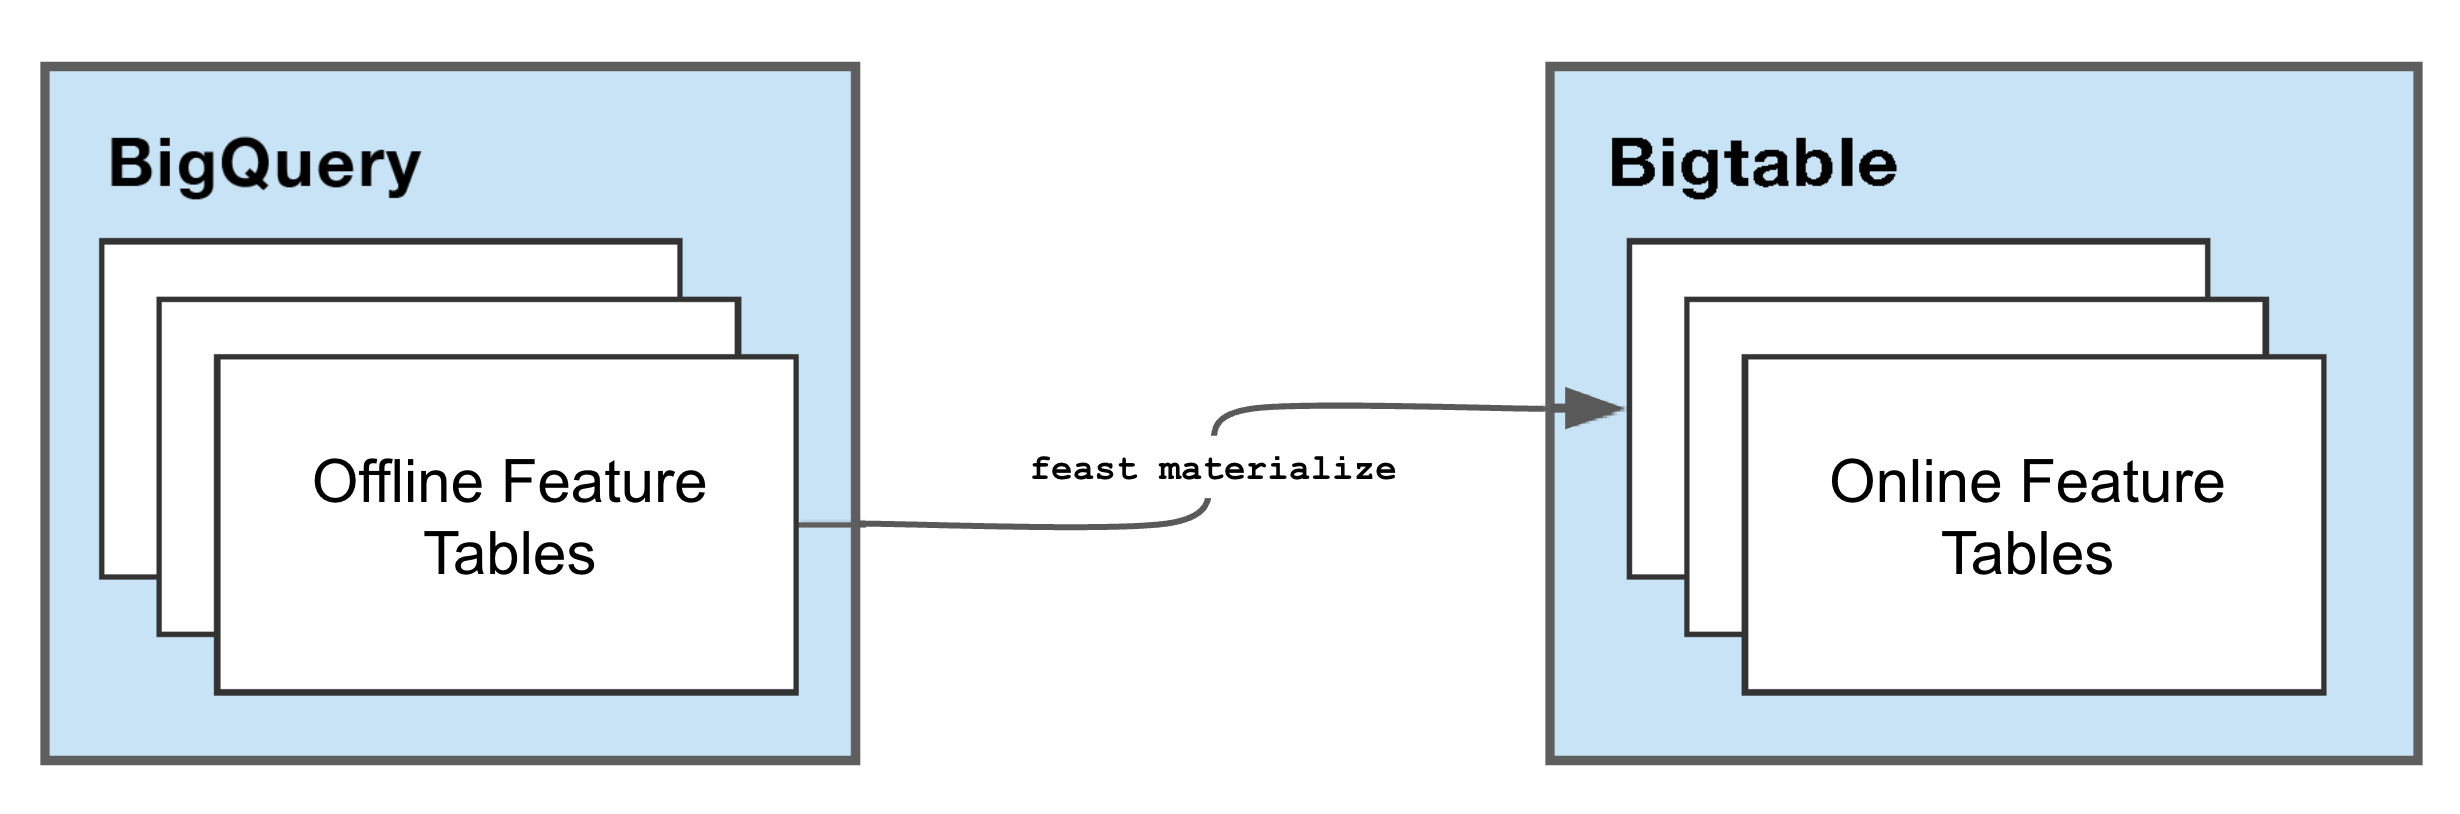

When writing a new feature, users will leverage Feast to backfill online features from historical data. Then they will, on a schedule, continuously incrementally process feature data to keep the online store up to date. Feast supports two kinds of materialization:

- `feast materialize <start-time> <end-time>` : this processes all feature values from the offline store within a given time range. Users commonly use this with another workflow orchestration system like Airflow which tracks the materialized data ranges.
- `feast materialize-incremental <end-time>`: this allows Feast to manage the materialization state and track what time ranges were already processed, so you only process new data.

In [21]:
!feast materialize-incremental $(date -u +"%Y-%m-%dT%H:%M:%S")

Materializing 1 feature views to 2023-07-19 23:53:16+00:00 into the bigtable online store.

purchased_product_categories from 2022-07-20 23:53:22+00:00 to 2023-07-19 23:53:16+00:00:
100%|███████████████████████████████████████████████████████| 15429/15429 [00:04<00:00, 3211.39it/s]


## Power model inference with `get_online_features`
Now you can use a very similar method to power online inference. `get_online_features` will retrieve the latest feature values for the given entity. Feast also allows you to stand up a feature server which exposes an HTTP API to provide the same functionality.


In [22]:
#get_online_features
from feast import RepoConfig, FeatureStore
from feast.repo_config import RegistryConfig

store = FeatureStore(repo_path=".")
features = store.get_online_features(
    features=store.get_feature_service("model_v1"),
    entity_rows=[
        {
            "user_id": 14,
        }
    ],
).to_dict()

In [23]:
for key, value in sorted(features.items()):
    print(key, " : ", value)

distinct_purchased_categories  :  [['Outerwear & Coats', 'Dresses']]
user_id  :  ['14']


# Clean up

### Tear down Feast resources

In [24]:
# Tear down Feast resources
!feast teardown

07/19/2023 11:54:00 PM feast.infra.online_stores.bigtable INFO: Deleting Bigtable table `RecSys.user_id`


### Delete Bigtable Instance

In [34]:
# Delete Bigtable Instance
def delete_bt_instance(project_id: str , instance_id: str):
  """ The function deletes Bigtable Instance
  """
  client = Client(project=project_id, admin=True)
  instance = client.instance(instance_id)

  print("\nDeleting instance")
  if not instance.exists():
      print("Instance {} does not exist.".format(instance_id))
  else:
      instance.delete()
      print("Deleted instance: {}".format(instance_id))

In [35]:
delete_bt_instance(PROJECT_ID, BIGTABLE_INSTANCE_NAME)


Deleting instance
Deleted instance: recsys-online-store-test-run


### Delete BigQuery Dataset

In [37]:
# Delete BigQuery Dataset
def delete_bq_dataset(project_id: str, dataset_id: str):
  """ The function deletes BigQuery dataset
  """
  # Construct a BigQuery client object
  client = bigquery.Client()
  dataset = project_id + '.' + dataset_id

  # Use the delete_contents parameter to delete a dataset and its contents.
  # Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
  client.delete_dataset(dataset_id, delete_contents=True, not_found_ok=True)  # Make an API request.
  print("Deleted dataset '{}'.".format(dataset_id))


In [38]:
delete_bq_dataset(PROJECT_ID, BIGQUERY_DATASET_NAME)

Deleted dataset 'recsys_offline_store_test_run'.


###Delete Cloud Storage bucket

In [47]:
#Delete Cloud Storage bucket; The bucket must be empty

def delete_bucket(bucket_name : str):
  """ The function deletes a bucket.
  The bucket must be empty"""
  #Construct a Cloud Storage client object
  storage_client = storage.Client()
  if storage_client.bucket(bucket_name).exists():
    bucket = storage_client.get_bucket(bucket_name)
    bucket.delete()
    print(f"Bucket {bucket.name} deleted")
  else:
    print(f"Bucket {bucket_name} doesnt exist")

In [48]:
delete_bucket(BUCKET_NAME)

Bucket recsys-test-run doesnt exist
